# 2. Sección de Ejercicios Computacionales

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

![caption](imgs/enunciado.png)

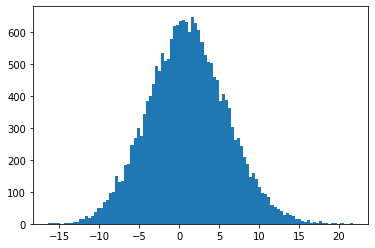

In [5]:
# Semilla aleatoria 
np.random.seed(seed=1234) # la clásica 123


# Parámetros principales
N, T, β1, β2 = 1000, 20, -1, 3


# Características de observaciones simuladas
X1 = np.random.normal(0, 4, size=N*T) # Arreglo de normal(0,4) de N x T


# Dummy género
D_i = np.random.choice([0,1], size=N, p=[0.6, 0.4])
D = np.repeat(D_i, T) # Repito cada valor para cada T de los individuos


# Shock aleatorio
u = np.random.uniform(-1,1,size=N*T)


# Efecto fijo
α_i = np.zeros(N)
α_i[D_i == 0] = np.random.normal(0,2,np.sum(D_i == 0)) # Hombres
α_i[D_i == 1] = np.random.normal(0,3,np.sum(D_i == 1)) # Mujeres
α = np.repeat(α_i, T) # Repito cada valor para cada T de los individuos


# # Matriz de 1's para los α_i (D de la clase)
# D = np.zeros((N*T, N), dtype=int)#.reshape(-N//100,T//10)
# for i in range(N):
#     D[T*i:T*(i+1),i] += 1


# Modelo (Matricial)
Y = β1 * X1 + β2 * D + α + u


# Visualización porque sí
plt.hist(Y, bins=100)
plt.show()

---

### Parte 1

---

![caption](imgs/p1.png)


Creamos algunas funciones auxiliares para facilitar la notación de álgebra lineal:

In [8]:
# Trasponer, Inversa, P. Punto, Diagonal
Transpose, Inverse, Dot, Diag = lambda A: np.transpose(A), lambda A: np.linalg.inv(A), lambda A, B: np.dot(A, B), lambda A: np.diag(A)

# Eigen values
Eigen = lambda A: np.linalg.eig(A)[0]

Primero juntamos las variables explicativas $X_1$ y $D$ en una sola matriz, además de un incercepto (así ignoramos el efecto por individuo y lo juntamos en un sólo parámetro). Luego, podemos ocupar los resultados conodicos de OLS clásico:

In [10]:
# Número de variables explicativas
K = 3

# Matriz de variables explicativas 
X = np.zeros((N*T, K)) # Incluye X y D
X[:,0] += 1
X[:,1]  = X1
X[:,2]  = D

# Estimador de los coeficientes clásico de OLS
β_OLS = Inverse( Transpose(X) @ X ) @ Transpose(X) @ Y

# Estimador de los residuos de OLS
u_OLS = ( Y - X @ β_OLS )

# Estimador de varianza de residuos
s2_OLS = Dot(u_OLS, u_OLS) / (N*T - K) # s^2

# Estimador de varianza de los coeficientes estimados
V_β_OLS = s2_OLS * Inverse( Transpose(X) @ X )

print('Coeficientes de OLS:')
print('α, β1, β1:', β_OLS)
print('-'*60)
print('Matriz de var-cov:')
print(V_β_OLS)

Coeficientes de OLS:
α, β1, β1: [-0.02594555 -1.00218946  3.09579399]
------------------------------------------------------------
Matriz de var-cov:
[[ 4.84823773e-04 -5.17479334e-08 -4.84820073e-04]
 [-5.17479334e-08  1.93879204e-05 -1.33439699e-06]
 [-4.84820073e-04 -1.33439699e-06  1.32113717e-03]]


---

### Parte 2

---

![caption](imgs/p2.png)


Para testear la hipótesis nula de que el error es homocedástico podemos utilizar el test de Wald

In [12]:
# Obtenemos la matriz D que se multiplica por el vecto de efectos fijos (α_1,...,α_N)
D_FE = np.zeros((N*T, N))
for i in range(N):
    D_FE[T*i:T*(i+1),i] += 1
D_FE

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

Calculamos ahora la transfomación de $X$ y de $y$ para poder obtener resultados tipo OLS 

In [14]:
# Matriz de variables explicativas para efectos fijos
K = 2
X_FE = np.zeros((N*T, K)) # Incluye X y D
X_FE[:,0]  = X1
X_FE[:,1]  = D
# print(X_FE)


# Transformación de X e y para ocupar resultados OLS
I_NT = np.identity(N*T)         # Identidad
Transformacion = (I_NT - D_FE @ Inverse( Transpose(D_FE) @ D_FE ) @ Transpose(D_FE) )
X_FE = Transformacion @ X_FE
Y_FE = Transformacion @ Y

# Estimador de los coeficientes
β_FE = Inverse( Transpose(X_FE) @ X_FE ) @ Transpose(X_FE) @ Y_FE
β_FE

array([-9.99677480e-01,  1.01748821e+13])

In [17]:
# Dataframe para simplificar el promedio
y_X_df =  pd.DataFrame({'Y':Y, 'X1':X1, 'D':D}) # D_i ya es su promedio en todo caso
y_X_df['i'] = [float(t//T+1) for t in range(T*N)]
y_X_means = y_X_df.groupby('i').mean().drop('D', axis=1)
y_X_df = y_X_df.join(y_X_means, on='i', how='right', rsuffix='_mean')
y_X_df.head()

,Y,X1,D,i,Y_mean,X1_mean
0,-0.178110,1.885741,0,1.0,1.186146,-0.045189
1,5.521073,-4.763903,0,1.0,1.186146,-0.045189
2,-5.019570,5.730828,0,1.0,1.186146,-0.045189
3,2.368787,-1.250608,0,1.0,1.186146,-0.045189
4,4.700061,-2.882355,0,1.0,1.186146,-0.045189


In [19]:
X_means = y_X_df.loc[:,['X1_mean', 'D']].to_numpy()
Y_means = y_X_df.Y.to_numpy()
α_FE = Y_means - X_means @ β_FE
u_FE = Y - α_FE - X_FE @ β_FE
u_FE

array([ 1.97548127e+00, -4.67201752e+00,  5.81932837e+00, ...,
        1.01748821e+13,  1.01748821e+13,  1.01748821e+13])

In [21]:
Y_WALD = u_FE**2
# X_WALD = X 
β_WALD = Inverse( Transpose(X) @ X ) @ Transpose(X) @ Y_WALD
β_WALD

array([-3.28852439e+10,  6.47789281e+12,  1.03528227e+26])

In [23]:
# Varianza
s2_FE = Dot(u_FE, u_FE) / (N*T - 3 ) # NT - K

# Test
R = np.array([ 
    [0, 1, 0],
    [0, 0, 1]
 ])
r = np.zeros(2)

Rβ_r = R @ β_WALD - r 
R_XX_R = R @ Inverse(Transpose(X) @ X) @ Transpose(R)
W = Transpose(Rβ_r) @ Inverse(R_XX_R) @ Rβ_r / s2_FE 

# Valor crítico
from scipy.stats.distributions import chi2
W_crit = chi2.ppf(0.9, df=2) # 2 restricciones, al 90% de confianza

# Resultado Test
if (W > W_crit): 
    print('Rechazamos H_0 (Homocedasticidad)') 
else: 
    print('Fallamos en rechazar H_0 (Homocedasticidad)')

Rechazamos H_0 (Homocedasticidad)


---

### Parte 3

---

![caption](imgs/p3.png)

In [25]:
# Término de en medio
X_diag_X = Transpose(X) @ Diag( u_OLS**2 ) @ X 

# Matriz var-cov E-W
V_β_EW = Inverse( Transpose(X) @ X ) @ X_diag_X @ Inverse( Transpose(X) @ X )
print('Mattriz de var-cov de Eicker-White:')
print(V_β_EW) 

Mattriz de var-cov de Eicker-White:
[[ 3.56659084e-04 -6.34913492e-07 -3.56612291e-04]
 [-6.34913492e-07  1.92047220e-05 -1.26245400e-06]
 [-3.56612291e-04 -1.26245400e-06  1.57390751e-03]]


In [27]:
# Valores propios de la diferencia
Eigen( V_β_OLS - V_β_EW ) # Tiene 1 valor propio negativo => Es semi-def negativa

array([-2.91900575e-04,  1.67296891e-04,  1.81229187e-07])

---

### Parte 4

---

![caption](imgs/p4.png)

Test de Wald

In [41]:
# Errores T x N
u_OLS_Matrix = u_OLS.reshape(T, N)

# t y (t-1)
u_OLS_Matrix_t =   u_OLS_Matrix[1: ,:].reshape(N*(T-1),)
u_OLS_Matrix_t_1 = u_OLS_Matrix[:-1,:].reshape(N*(T-1),)

# Sumas auxiliares del estadístico
sum_u_t_1_t_1   = np.sum( u_OLS_Matrix_t_1 ** 2 )
sum_u_t_t_1 = np.sum( u_OLS_Matrix_t * u_OLS_Matrix_t_1 )
# 
ϕ_OMS =  sum_u_t_t_1 /( sum_u_t_1_t_1 )

# Estadístico
ρ_AR = np.sqrt( N*T ) * ϕ_OMS

# Test
if ρ_AR > 1.96: # 5% de significancia
    print('Se rechaza H_0 (Autoregresión)')
else:
    print('Se rechaza H_0 (Autoregresión)')

Se rechaza H_0 (Autoregresión)


---

### Parte 5

---

![caption](imgs/p5.png)

$\beta_1, \beta_2, \alpha, \phi, \rho$